In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import graphviz
import random

class DecisionNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, *, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def gini(y):
    classes = np.unique(y)
    impurity = 1
    for cls in classes:
        p_cls = np.mean(y == cls)
        impurity -= p_cls ** 2
    return impurity

def mse(y):
    return np.mean((y - np.mean(y)) ** 2)

class DecisionTree:
    def __init__(self, 
                 task='classification', 
                 max_depth=100, 
                 min_samples_split=2, 
                 min_impurity_decrease=1e-7,
                 n_features=None):
        self.task = task
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        self.root = None
        self.n_features = n_features  # Number of features to consider at each split
        
        if self.task == 'classification':
            self.criterion = gini
        elif self.task == 'regression':
            self.criterion = mse
        else:
            raise ValueError("Task must be 'classification' or 'regression'.")

    def fit(self, X, y):
        self.root = self._build_tree(X, y)
    
    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        current_impurity = self.criterion(y)
        
        if (depth >= self.max_depth or 
            num_samples < self.min_samples_split or 
            current_impurity == 0):
            leaf_value = self._calculate_leaf_value(y)
            return DecisionNode(value=leaf_value)
        
        if self.n_features is not None:
            features = random.sample(range(num_features), self.n_features)
        else:
            features = range(num_features)
        
        best_feature, best_threshold, best_impurity_decrease = self._best_split(X, y, current_impurity, features)
        
        if best_impurity_decrease < self.min_impurity_decrease:
            leaf_value = self._calculate_leaf_value(y)
            return DecisionNode(value=leaf_value)
        
        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold
        left = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        return DecisionNode(feature_index=best_feature, threshold=best_threshold, left=left, right=right)
    
    def _best_split(self, X, y, current_impurity, features):
        num_samples, num_features = X.shape
        best_impurity_decrease = 0
        best_feature, best_threshold = None, None
        
        for feature in features:
            sorted_indices = X[:, feature].argsort()
            X_sorted, y_sorted = X[sorted_indices], y[sorted_indices]
            
            for i in range(1, num_samples):
                if self.task == 'classification' and y_sorted[i] == y_sorted[i-1]:
                    continue  
                threshold = (X_sorted[i][feature] + X_sorted[i-1][feature]) / 2
                if self.task == 'classification':
                    left = y_sorted[:i]
                    right = y_sorted[i:]
                    impurity = (len(left) / num_samples) * self.criterion(left) + \
                               (len(right) / num_samples) * self.criterion(right)
                else:
                    left = y_sorted[:i]
                    right = y_sorted[i:]
                    impurity = (len(left) / num_samples) * self.criterion(left) + \
                               (len(right) / num_samples) * self.criterion(right)
                
                impurity_decrease = current_impurity - impurity
                
                if impurity_decrease > best_impurity_decrease:
                    best_impurity_decrease = impurity_decrease
                    best_feature = feature
                    best_threshold = threshold
                    
        return best_feature, best_threshold, best_impurity_decrease
    
    def _calculate_leaf_value(self, y):
        if self.task == 'classification':
            values, counts = np.unique(y, return_counts=True)
            return values[np.argmax(counts)]
        else:
            return np.mean(y)
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_index] < node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)
    
    def to_graphviz(self):
        dot = graphviz.Digraph()
        self._add_nodes(dot, self.root)
        return dot
    
    def _add_nodes(self, dot, node, parent=None, edge_label=""):
        if node.value is not None:
            label = f"Leaf\nValue: {node.value}"
            dot.node(str(id(node)), label=label, shape='ellipse', style='filled', color='lightgrey')
        else:
            label = f"X{node.feature_index} < {node.threshold:.2f}"
            dot.node(str(id(node)), label=label, shape='box')
        
        if parent is not None:
            dot.edge(str(id(parent)), str(id(node)), label=edge_label)
        
        if node.left:
            self._add_nodes(dot, node.left, parent=node, edge_label="<")
        if node.right:
            self._add_nodes(dot, node.right, parent=node, edge_label=">=")


In [2]:
class RandomForest:
    def __init__(self, 
                 n_estimators=100, 
                 task='classification', 
                 max_depth=100, 
                 min_samples_split=2, 
                 min_impurity_decrease=1e-7,
                 max_features='sqrt',
                 random_state=None):
        self.n_estimators = n_estimators
        self.task = task
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        if self.random_state:
            np.random.seed(self.random_state)
            random.seed(self.random_state)
    
    def _get_max_features(self, n_features):
        if self.max_features == 'sqrt':
            return int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            return int(np.log2(n_features))
        elif isinstance(self.max_features, int):
            return self.max_features
        elif self.max_features is None:
            return n_features
        else:
            raise ValueError("Invalid value for max_features.")
    
    def fit(self, X, y):
        self.trees = []
        n_samples, n_features = X.shape
        max_features = self._get_max_features(n_features)
        
        for i in range(self.n_estimators):
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            
            tree = DecisionTree(
                task=self.task,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_impurity_decrease=self.min_impurity_decrease,
                n_features=max_features
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
    
    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        
        if self.task == 'classification':
            predictions = []
            for preds in tree_preds.T:
                values, counts = np.unique(preds, return_counts=True)
                predictions.append(values[np.argmax(counts)])
            return np.array(predictions)
        else:
            return np.mean(tree_preds, axis=0)


In [8]:
def plot_decision_boundary(tree, X, y, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    resolution = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = tree.predict(grid)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdBu)
    plt.scatter(X[y==0][:,0], X[y==0][:,1], color='red', label='Class 0', edgecolor='k')
    plt.scatter(X[y==1][:,0], X[y==1][:,1], color='blue', label='Class 1', edgecolor='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_regression_decision_boundary(tree, X, y, title="Decision Boundary - Regression"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    resolution = 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = tree.predict(grid)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    plt.colorbar(contour, label='Predicted Value')
    plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', edgecolor='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.show()

def classification_example_random_forest():
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    
    X, y = make_classification(n_samples=200, n_features=2, 
                               n_redundant=0, n_clusters_per_class=1,
                               class_sep=1.5, random_state=42)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.3, 
                                                        random_state=42)
    
    rf = RandomForest(
        n_estimators=10,
        task='classification',
        max_depth=5,
        min_samples_split=2,
        min_impurity_decrease=1e-7,
        max_features='sqrt',
        random_state=42
    )
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Random Forest Classification Accuracy: {accuracy:.4f}')
    
    plot_decision_boundary(rf, X_train, y_train, title="Random Forest Decision Boundary - Classification")


def regression_example_random_forest():
    from sklearn.datasets import make_regression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    
    X, y = make_regression(n_samples=200, n_features=2, noise=15.0, random_state=42)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.3, 
                                                        random_state=42)
    
    rf = RandomForest(
        n_estimators=10,
        task='regression',
        max_depth=5,
        min_samples_split=2,
        min_impurity_decrease=1e-7,
        max_features='sqrt',
        random_state=42
    )
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    print(f'Random Forest Regression MSE: {mse:.4f}')
    
    plot_regression_decision_boundary(rf, X_train, y_train, title="Random Forest Decision Boundary - Regression")



Random Forest Classification Accuracy: 0.9333


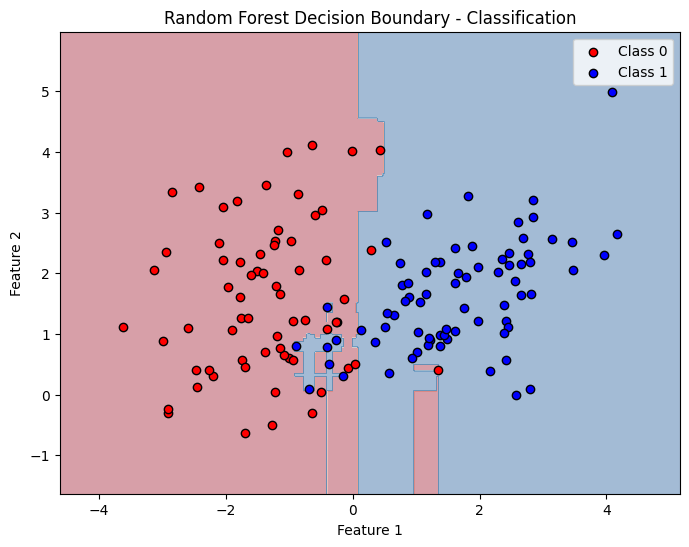

Random Forest Regression MSE: 626.4494


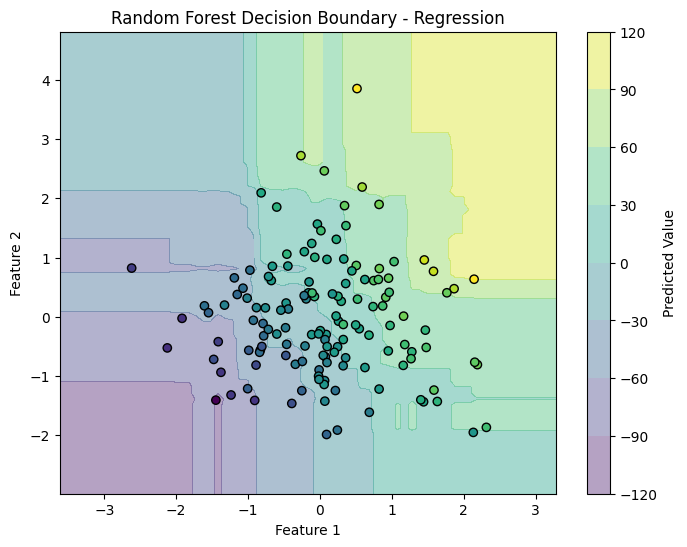

In [9]:
classification_example_random_forest()
regression_example_random_forest()